<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Setup
(No need to change anything)

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-m1l8h6b4
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-m1l8h6b4
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 318236402ddcc9cabace3f2fca40c71f0c2e9e57
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
# import datasets
from IPython.display import HTML

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
# torch.set_grad_enabled(False)

# Load Model

In [6]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [8]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [11]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Load Dataset

In [12]:
# nw = [
#     "January", "February", "March", "April", "May", "June",
#     "July", "August", "September", "October", "November", "December"
# ]
# # nw = [
# #     "Jan", "Feb", "Mar", "Apr", "May", "Jun",
# #     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
# # ]

# prompts = ["{} {} {} {} {} {} {} {} {}".format(i, nw[i], i+1, nw[i+1], i+2, nw[i+2], i+3, nw[i+3], i+4) for i in range(0, 8)]

In [13]:
# # inorder

# nw = [
#     "January", "February", "March", "April", "May", "June",
#     "July", "August", "September", "October", "November", "December"
# ]

# numwords = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

# prompts = ["{} {} {} {} {} {} {} {} {}".format(numwords[i], nw[i], numwords[i+1], nw[i+1], numwords[i+2], nw[i+2], numwords[i+3], nw[i+3], numwords[i+4]) for i in range(0, 5)]

# print(prompts)


In [14]:
import random

# months = [
#     "Jan", "Feb", "Mar", "Apr", "May", "Jun",
#     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
# ]

months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

numwords = [
    "one", "two", "three", "four", "five", "six", "seven", "eight",     "nine"]

prompts = []
for j in range(1):  # number of random order digit sets
    r1 = random.choice(numwords[:])
    r2 = random.choice(numwords[4:])
    r3 = random.choice(numwords[:])
    r4 = numwords[numwords.index(r2)-1]
    r5 = random.choice(numwords[:])
    for i in range(0, 5):  # loop thru months in order
        prompt = "{} {} {} {} {} {} {} {} {}".format(r1, months[i], r2, months[i+1], r3, months[i+2], r4, months[i+3], r5)
        prompts.append(prompt)

print(prompts)
print(len(prompts))

['four January five February nine March four April six', 'four February five March nine April four May six', 'four March five April nine May four June six', 'four April five May nine June four July six', 'four May five June nine July four August six']
5


In [22]:
tokens = model.to_tokens(prompts, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU
original_logits, local_cache = model.run_with_cache(tokens) # Run the model and cache all activations

local_tokens = tokens[0]
# Tokenized sentence is stored in token_list and the tokens you are interested in are token1 and token2
token_list = model.to_str_tokens(local_tokens)

In [43]:
token_list

['<s>',
 'four',
 'January',
 'five',
 'February',
 'nine',
 'March',
 'four',
 'April',
 'six']

In [23]:
import gc

del(original_logits)
# del(local_cache)
torch.cuda.empty_cache()
gc.collect()

0

# Attention Analysis setup

## Index attn pat fns

In [19]:
def get_ind(token_list, token1, token2, printInd=False):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:
        if printInd:
            print(f"The index of '{token1}' is {query_ind}")
            print(f"The index of '{token2}' is {key_ind}")
    return query_ind, key_ind

# Early heads

## Number Detection/Similar Type Heads

In [50]:
def visualize_attention_patterns(
    layer, head_index,
    highlightLines = True,
    savePlotName = ''
):
    patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy() # Convert tensor to numpy for visualization

    # Convert tokens to string
    local_tokens = tokens[0]
    str_tokens = model.to_str_tokens(local_tokens)
    str_tokens[0] = '<PAD>' # Rename the first token string as '<END>'
    # Truncate token strings to max length of 3 characters
    months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    str_tokens = [token[:3] if token in months else token for token in str_tokens]

    # Create a mask for the cells above the diagonal
    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        # cmap='viridis',
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,  # Set linewidth to create grid lines between cells
        linecolor='white',  # Set line color to white
        # cbar_kws={'label': 'Attention Weight'}
        mask=mask
    )

    # Move x-axis ticks to the top
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position('top')

    # Rotate y-axis labels to be horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.set_xlabel('Key', fontsize=16, fontweight='bold', labelpad=20)
    ax.set_ylabel('Query', fontsize=16, fontweight='bold', labelpad=20)

    if highlightLines:
        token_pairs_highL = [('February', 'January'), ('March', 'February'), ('April', 'March')]
        # token_pairs_highL = [('Feb', 'Jan'), ('Mar', 'Feb'), ('Apr', 'Mar')]

        for qk_toks in token_pairs_highL:
            qInd, kInd = get_ind(token_list, qk_toks[0], qk_toks[1])
            plt.plot([0, kInd+1], [qInd, qInd], color='#7FFF00', linewidth=5)  # top of highL row; pink- FF33D4 ; red- FF3C33 ; FF69B4
            # plt.plot([0, kInd+1], [qInd+1, qInd+1], color='lime', linewidth=3.5)  # bot of highL row ; 3390FF
            # plt.plot([kInd, kInd], [qInd, len(str_tokens)], color='cyan', linewidth=3.5)  # left of highL col
            plt.plot([kInd+1, kInd+1], [qInd, len(str_tokens)], color='blue', linewidth=5)  # right of highL col

            # Change the color of highL row and col ticklabels
            yticklabels = ax.get_yticklabels()
            yticklabels[qInd].set_color('green')
            yticklabels[qInd].set_fontweight('bold')  # Optionally make it bold
            yticklabels[qInd].set_fontsize(14)
            ax.set_yticklabels(yticklabels)
            xticklabels = ax.get_xticklabels()
            xticklabels[kInd].set_color('blue')
            xticklabels[kInd].set_fontweight('bold')  # Optionally make it bold
            xticklabels[kInd].set_fontsize(14)
            ax.set_xticklabels(xticklabels)

    if savePlotName != '':
        plt.savefig(savePlotName + '.pdf', bbox_inches='tight')
        files.download(savePlotName + '.pdf')
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

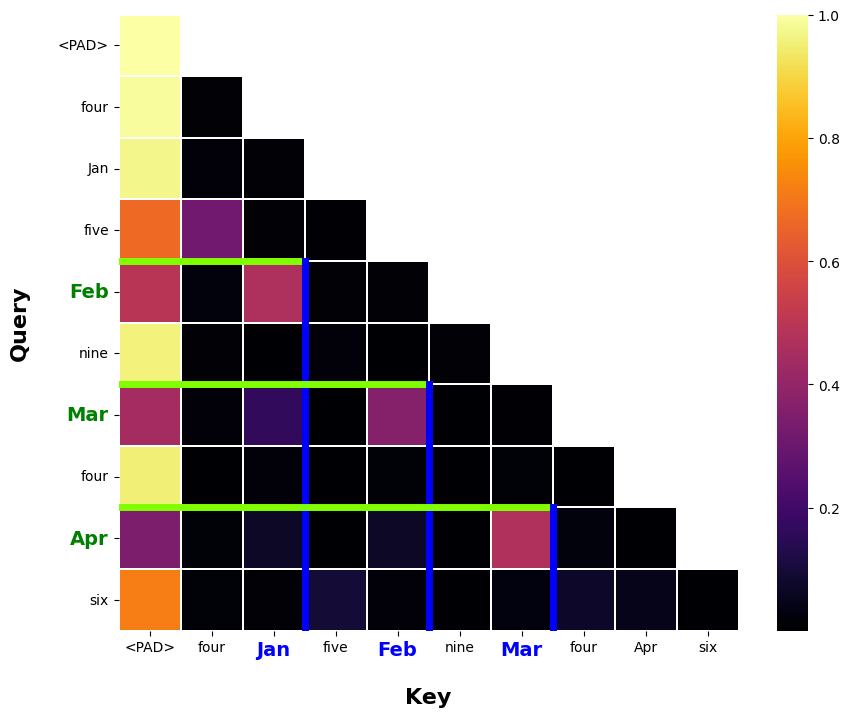

In [51]:
visualize_attention_patterns(layer = 5, head_index = 25, highlightLines=True, savePlotName='attnpat1_5_among_months')

# rand order numwords, inorder months